# XGB test


In [1]:
%load_ext autoreload
%autoreload 2

# %matplotlib widget

In [2]:
import pandas as pd

import seaborn as sns

from math import log

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from xgboost import XGBRegressor
# import shap


from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

from plots2.fns import (
    get_corner_annotations,
    get_corner_annotations_custom_labels,
)

from poly2.utils import trait_vec, gamma_dist, object_dump, object_load
from poly2.config import Config

C:\Users\user\anaconda3\envs\poly2\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
from poly2.utils import load_train_test_data, HyperparamsObj
import optuna
from optuna.samplers import TPESampler

# combine hyperparam dfs

In [4]:
def combine_hyperparam_dfs(model):
    df = (
        pd.read_csv(f'../outputs/hyperparams/{model}.csv')
        .sort_values('best_cv_score')
    )
    
    if True:
        fn = f'../outputs/hyperparams/best/{model}.csv'
        print(f'saving to {fn}')
        df.head(1).to_csv(fn, index=False)
    return df

In [13]:
MODEL = 'asymp'

In [14]:
df = combine_hyperparam_dfs(MODEL)

saving to ../outputs/hyperparams/best/asymp.csv


In [15]:
df.head()

,max_depth,n_estimators,learning_rate,subsample,colsample_bytree,tree_method,model,default_cv_score,best_cv_score,rmse_test,rmse_train,rmse_test_def,number
99,10,1740,0.019909,0.546807,0.887985,hist,asymp,0.149522,0.117331,0.116259,0.039730,0.15013,3
92,11,1312,0.026453,0.504260,0.942453,hist,asymp,0.149522,0.118195,0.117108,0.029533,0.15013,21
2,10,1426,0.039033,0.693450,0.913072,hist,asymp,0.149522,0.118315,0.117620,0.029628,0.15013,47
180,11,1033,0.017964,0.762333,0.955785,hist,asymp,0.149522,0.118479,0.117928,0.035552,0.15013,40
135,9,1409,0.025953,0.943912,0.887952,hist,asymp,0.149522,0.118626,0.117846,0.049861,0.15013,7


Visualise the dataset of the best result from each of the 200 runs of 50

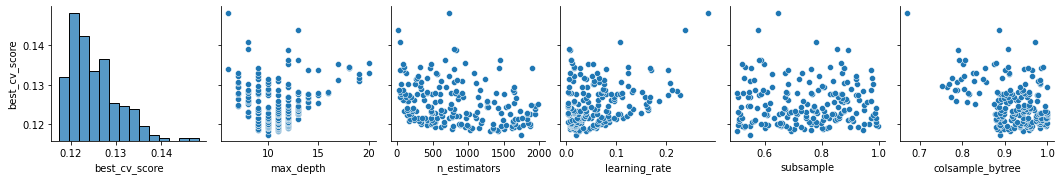

In [16]:
sns.pairplot(
    df.loc[:, [
        'best_cv_score', 
        'max_depth',
        'n_estimators',
        'learning_rate',
        'subsample',
        'colsample_bytree',
    ]],
    # corner=True,
    y_vars=['best_cv_score'],
    # hue='best_cv_score',
    # palette='rocket',
)

# Can we replicate?

Might have to be satisfied if agree to XX s.f. because of floating point errors / inexact saving

In [17]:
best_pars = (
    df
    .head(1)
    .loc[:, [
        'max_depth',
        'n_estimators',
        'learning_rate',
        'subsample',
        'colsample_bytree',
        'tree_method',
    ]]
    .iloc[0]
    .to_dict()
)

In [18]:
best_pars

{'max_depth': 10,
 'n_estimators': 1740,
 'learning_rate': 0.0199085136730978,
 'subsample': 0.5468065466488763,
 'colsample_bytree': 0.8879850476692774,
 'tree_method': 'hist'}

In [301]:
X_train, y_train, X_test, y_test = load_train_test_data(MODEL)

In [302]:
best_model = XGBRegressor(**best_pars).fit(X_train, y_train)

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [303]:
yp_train = best_model.predict(X_train)
yp_test = best_model.predict(X_test)

In [304]:
rmse_train = mean_squared_error(yp_train, y_train, squared=False)
rmse_test = mean_squared_error(yp_test, y_test, squared=False)

In [305]:
rmse_test.round(6), rmse_train.round(6)

(0.044345, 0.016473)

In [19]:
df.filter(like='rmse_').head(1).drop(['rmse_test_def'], axis=1)

,rmse_test,rmse_train
99,0.116259,0.03973


In [23]:
(
    df
    .head(1)
    # .loc[:,
    #      ['
    .round(5)
    .iloc[0]
    .to_dict()
)

{'max_depth': 10,
 'n_estimators': 1740,
 'learning_rate': 0.01991,
 'subsample': 0.54681,
 'colsample_bytree': 0.88799,
 'tree_method': 'hist',
 'model': 'asymp',
 'default_cv_score': 0.14952,
 'best_cv_score': 0.11733,
 'rmse_test': 0.11626,
 'rmse_train': 0.03973,
 'rmse_test_def': 0.15013,
 'number': 3}